<a href="https://colab.research.google.com/github/aniketinamdar/Text-To-Images-Models/blob/main/openai_glide.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/openai/glide-text2im.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/glide-text2im.git to /tmp/pip-req-build-rrhe5op7
  Running command git clone --filter=blob:none --quiet https://github.com/openai/glide-text2im.git /tmp/pip-req-build-rrhe5op7
  Resolved https://github.com/openai/glide-text2im.git to commit 69b530740eb6cef69442d6180579ef5ba9ef063e
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 3.0 MB/s eta 0:00:00
  Created wheel for glide-text2im: filename=glide_text2im-0.0.0-py3-none-any.whl size=1953625 sha256=9fca099f5440598203d46224749e54cb9b10a6810e25f2d31a7b687e3400117a
  Stored in directory: /tmp/pip-ephem-wheel-cache-g8z4c69s/wheels/48/55/6b/286c6381584d5c01dee719a333e55ad0b839c673193857934a
Successfully built glide-text2im


In [ ]:
from PIL import Image
from IPython.display import display
import torch as th

from glide_text2im.download import load_checkpoint
from glide_text2im.model_creation import (
    create_model_and_diffusion,
    model_and_diffusion_defaults,
    model_and_diffusion_defaults_upsampler
)

In [ ]:
has_cuda = th.cuda.is_available()
device = th.device('cpu' if not has_cuda else 'cuda')

#Base model

In [ ]:
options = model_and_diffusion_defaults()
options['use_fp16'] = has_cuda
options['timestep_respacing'] = '100'
model, diffusion = create_model_and_diffusion(**options)
model.eval()
if has_cuda:
    model.convert_to_fp16()
model.to(device)
model.load_state_dict(load_checkpoint('base', device))
print('total base parameters', sum(x.numel() for x in model.parameters()))

  0%|          | 0.00/1.54G [00:00<?, ?iB/s]

total base parameters 385030726


#Upsampler model

In [ ]:
options_up = model_and_diffusion_defaults_upsampler()
options_up['use_fp16'] = has_cuda
options_up['timestep_respacing'] = 'fast27' # use 27 diffusion steps for very fast sampling
model_up, diffusion_up = create_model_and_diffusion(**options_up)
model_up.eval()
if has_cuda:
    model_up.convert_to_fp16()
model_up.to(device)
model_up.load_state_dict(load_checkpoint('upsample', device))
print('total upsampler parameters', sum(x.numel() for x in model_up.parameters()))

  0%|          | 0.00/1.59G [00:00<?, ?iB/s]

total upsampler parameters 398361286


In [ ]:
def show_images(batch: th.Tensor):
    scaled = ((batch + 1)*127.5).round().clamp(0,255).to(th.uint8).cpu()
    reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])
    display(Image.fromarray(reshaped.numpy()))

In [ ]:
# prompt = "an oil painting of a corgi"
prompt ='lion barking'
batch_size = 1
guidance_scale = 3.0

upsample_temp = 0.997

#Sample from the base model

  0%|          | 0/100 [00:00<?, ?it/s]

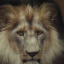

In [ ]:
tokens = model.tokenizer.encode(prompt)
tokens, mask = model.tokenizer.padded_tokens_and_mask(
    tokens, options['text_ctx']
)

full_batch_size = batch_size * 2
uncond_tokens, uncond_mask = model.tokenizer.padded_tokens_and_mask(
    [], options['text_ctx']
)

model_kwargs = dict(
    tokens=th.tensor(
        [tokens] * batch_size + [uncond_tokens] * batch_size, device=device
    ),
    mask=th.tensor(
        [mask] * batch_size + [uncond_mask] * batch_size,
        dtype=th.bool,
        device=device,
    ),
)

def model_fn(x_t, ts, **kwargs):
    half = x_t[: len(x_t) // 2]
    combined = th.cat([half, half], dim=0)
    model_out = model(combined, ts, **kwargs)
    eps, rest = model_out[:, :3], model_out[:, 3:]
    cond_eps, uncond_eps = th.split(eps, len(eps) // 2, dim=0)
    half_eps = uncond_eps + guidance_scale * (cond_eps - uncond_eps)
    eps = th.cat([half_eps, half_eps], dim=0)
    return th.cat([eps, rest], dim=1)

model.del_cache()
samples = diffusion.p_sample_loop(
    model_fn,
    (full_batch_size, 3, options["image_size"], options["image_size"]),
    device=device,
    clip_denoised=True,
    progress=True,
    model_kwargs=model_kwargs,
    cond_fn=None,
)[:batch_size]
model.del_cache()

show_images(samples)

#Upsample the output image

  0%|          | 0/27 [00:00<?, ?it/s]

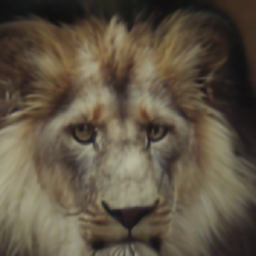

In [ ]:
tokens = model_up.tokenizer.encode(prompt)
tokens, mask = model_up.tokenizer.padded_tokens_and_mask(
    tokens, options_up['text_ctx']
)

model_kwargs = dict(
    low_res=((samples+1)*127.5).round()/127.5 - 1,

    tokens=th.tensor(
        [tokens] * batch_size, device=device
    ),
    mask=th.tensor(
        [mask] * batch_size,
        dtype=th.bool,
        device=device,
    ),
)

model_up.del_cache()
up_shape = (batch_size, 3, options_up["image_size"], options_up["image_size"])
up_samples = diffusion_up.ddim_sample_loop(
    model_up,
    up_shape,
    noise=th.randn(up_shape, device=device) * upsample_temp,
    device=device,
    clip_denoised=True,
    progress=True,
    model_kwargs=model_kwargs,
    cond_fn=None,
)[:batch_size]
model_up.del_cache()

show_images(up_samples)